# Unified Deep-CBN Training
This notebook provides a unified training function capable of handling both classification and regression tasks using the Deep-CBN architecture.

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from deepchem.data import NumpyDataset
from deepchem.splits import ScaffoldSplitter


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [5]:
# Character dictionary used to encode SMILES strings
# Dictionary for converting SMILES characters to numbers
smiles_dict = {
    "#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
    "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
    "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
    "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
    "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
    "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56,
    "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60,
    "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64,
    " ": 65, ":": 66, ",": 67, "p": 68, "j": 69, "*": 70
}

MAX_SMI_LEN = 100
NUM_CHARS = 71

def label_smiles(line):
    X = np.zeros(MAX_SMI_LEN, dtype=int)
    for i, ch in enumerate(line[:MAX_SMI_LEN]):
        if ch in smiles_dict:
            X[i] = smiles_dict[ch]
    return X


In [6]:
def build_models(mode):
    inp = layers.Input(shape=(MAX_SMI_LEN, NUM_CHARS), name='XDinput')
    x = layers.Conv1D(64, 2, activation='relu')(inp)
    x = layers.Conv1D(64, 4, activation='relu')(x)
    x = layers.Conv1D(128, 4, activation='relu')(x)
    feature_output = x
    feature_model = models.Model(inp, feature_output, name='model_feature')

    pred_inp = layers.Input(shape=(feature_output.shape[1], feature_output.shape[2]))
    y = layers.GlobalAveragePooling1D()(pred_inp)
    y = layers.Dense(512, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.1)(y)
    y = layers.Dense(256, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.1)(y)
    y = layers.Dense(64, activation='relu')(y)
    if mode == 'classification':
        outputs = layers.Dense(2, activation='softmax')(y)
    else:
        outputs = layers.Dense(1)(y)
    pred_model = models.Model(pred_inp, outputs, name='model_pred')

    inter_out = pred_model(feature_output)
    interaction_model = models.Model(inp, inter_out, name='interactionModel')
    return feature_model, pred_model, interaction_model


In [7]:
def evaluate_metrics(y_true, y_pred, mode):
    if mode == 'classification':
        proba = y_pred[:, 1]
        pred_cls = np.argmax(y_pred, axis=1)
        fpr, tpr, _ = roc_curve(y_true, proba)
        return {
            'accuracy': accuracy_score(y_true, pred_cls),
            'precision': precision_score(y_true, pred_cls, zero_division=0),
            'recall': recall_score(y_true, pred_cls, zero_division=0),
            'f1': f1_score(y_true, pred_cls, zero_division=0),
            'auc': roc_auc_score(y_true, proba),
            'roc': {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}
        }
    else:
        pred = y_pred.squeeze()
        return {
            'mae': mean_absolute_error(y_true, pred),
            'mse': mean_squared_error(y_true, pred),
            'r2': r2_score(y_true, pred)
        }


In [8]:
def train_deep_cbn(df, target_col, mode="classification", epochs=25, smiles_col="smiles", scaffold_split=False):
    smiles = df[smiles_col].astype(str)
    y = df[target_col]
    X = np.array([label_smiles(s) for s in smiles])
    X = to_categorical(X, num_classes=NUM_CHARS)

    if scaffold_split:
        labels_np = y.values
        index = ~np.isnan(labels_np)
        labels_np = labels_np[index]
        X_f = X[index]
        smiles_filtered = smiles.iloc[index].values
        dataset = NumpyDataset(X=X_f, y=labels_np, ids=smiles_filtered)
        splitter = ScaffoldSplitter()
        train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
            dataset, frac_train=0.8, frac_valid=0.1, frac_test=0.1
        )
        smiles_to_index = {s: idx for idx, s in enumerate(smiles_filtered)}
        train_indices = np.array([smiles_to_index[s] for s in train_dataset.ids])
        test_indices = np.array([smiles_to_index[s] for s in test_dataset.ids])
        X_train, X_test = X_f[train_indices], X_f[test_indices]
        y_train, y_test = labels_np[train_indices], labels_np[test_indices]
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y.values, test_size=0.2, random_state=42,
            stratify=y if mode=="classification" else None)

    y_train_in = to_categorical(y_train, num_classes=2) if mode=="classification" else y_train
    y_test_in = to_categorical(y_test, num_classes=2) if mode=="classification" else y_test

    feat_model, pred_model, inter_model = build_models(mode)

    if mode == "classification":
        loss = "categorical_crossentropy"
        METRICS = [metrics.CategoricalAccuracy(name='accuracy'),
                   metrics.Precision(name='precision'),
                   metrics.Recall(name='recall'),
                   metrics.AUC(name='auc')]
    else:
        loss = "mse"
        METRICS = [metrics.MeanAbsoluteError(name='mae'),
                   metrics.MeanSquaredError(name='mse')]

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

    # === Phase 1 ===
    print(f"Starting Phase 1 training for target '{target_col}' ({mode})")
    inter_model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=METRICS)
    inter_model.fit(X_train, y_train_in, epochs=epochs, batch_size=256, callbacks=[es], verbose=1)
    phase1_pred = inter_model.predict(X_test)
    phase1_metrics = evaluate_metrics(y_test, phase1_pred, mode)

    # === Phase 2 ===
    print(f"Starting Phase 2 training for target '{target_col}' ({mode})")
    feature_train = feat_model.predict(X_train)
    feature_test = feat_model.predict(X_test)
    model_phaz2 = models.clone_model(pred_model)
    model_phaz2.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=METRICS)
    model_phaz2.fit(feature_train, y_train_in, epochs=epochs, batch_size=256, callbacks=[es], verbose=1)
    phase2_pred = model_phaz2.predict(feature_test)
    phase2_metrics = evaluate_metrics(y_test, phase2_pred, mode)

    # === Phase 3 ===
    print(f"Starting Phase 3 training for target '{target_col}' ({mode})")
    inputs = feat_model.input
    outputs = pred_model(feat_model.output)
    model_phaz3 = models.Model(inputs, outputs, name='model_phase3')
    model_phaz3.compile(optimizer=optimizers.Adam(1e-4), loss=loss, metrics=METRICS)
    model_phaz3.fit(X_train, y_train_in, epochs=epochs, batch_size=256, callbacks=[es], verbose=1)
    phase3_train_pred = model_phaz3.predict(X_train)
    phase3_test_pred = model_phaz3.predict(X_test)
    phase3_train_metrics = evaluate_metrics(y_train, phase3_train_pred, mode)
    phase3_test_metrics = evaluate_metrics(y_test, phase3_test_pred, mode)

    results = {
        'phase1': phase1_metrics,
        'phase2': phase2_metrics,
        'phase3_train': phase3_train_metrics,
        'phase3_test': phase3_test_metrics
    }
    if mode == 'classification':
        results['roc'] = phase3_test_metrics.pop('roc')
    return model_phaz3, results


# Example usage on Classifcation Tasks

In [13]:
# Example usage on multiple targets
data = pd.read_csv('../Data/tox21.csv')
targets = ['NR-AR', 'NR-ER', 'NR-PPAR-gamma']
summary = {}
for tgt in targets:
    df = data[[tgt, 'smiles']].dropna()
    model, metrics_dict = train_deep_cbn(df, tgt, mode='classification', epochs=10, scaffold_split= False)
    summary[tgt] = metrics_dict

Starting Phase 1 training for target 'NR-AR' (classification)
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8907 - auc: 0.9341 - loss: 0.2917 - precision: 0.8907 - recall: 0.8907
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9608 - auc: 0.9810 - loss: 0.1394 - precision: 0.9608 - recall: 0.9608
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9663 - auc: 0.9832 - loss: 0.1304 - precision: 0.9663 - recall: 0.9663
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9749 - auc: 0.9854 - loss: 0.1090 - precision: 0.9749 - recall: 0.9749
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9725 - auc: 0.9860 - loss: 0.1110 - precision: 0.9725 - recall: 0.9725
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9688 - auc: 0.9872 - loss: 0.1126 - precision: 0.9688 - recall: 0.9688
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9718 - auc: 0.9877 - loss: 0.1132 - precision: 0.9718 - r

## Performance

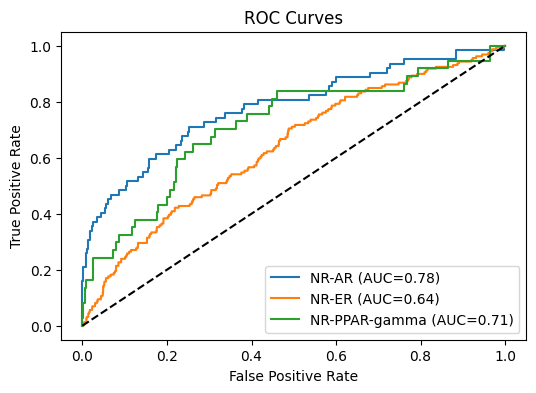

,target,accuracy,precision,recall,f1,auc
0,NR-AR,0.957330,0.0,0.0,0.0,0.778426
1,NR-ER,0.871671,0.0,0.0,0.0,0.636766
2,NR-PPAR-gamma,0.971318,0.0,0.0,0.0,0.714652


In [14]:
# Summarize performance metrics and plot ROC curves
summary_rows = []
plt.figure(figsize=(6,4))
for target, met in summary.items():
    row = {'target': target}
    row.update(met.get('phase3_test', {}))
    summary_rows.append(row)
    roc = met.get('roc')
    if roc:
        plt.plot(roc['fpr'], roc['tpr'], label=f"{target} (AUC={met['phase3_test']['auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
summary_df = pd.DataFrame(summary_rows)
summary_df

# Example Usage on Regression Tasks

In [15]:
# Example usage on regression task
data = pd.read_csv('../Data/freesolv.csv')
targets = ['freesolv']
summary = {}
for tgt in targets:
    df = data[[tgt, 'smiles']].dropna()
    model, metrics_dict = train_deep_cbn(df, tgt, mode='regression', epochs= 100000, scaffold_split= False)
    summary[tgt] = metrics_dict

    smiles = df['smiles'].astype(str)
    y = df[tgt].values
    X = np.array([label_smiles(s) for s in smiles])
    X = to_categorical(X, num_classes=NUM_CHARS)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    preds = model.predict(X_test).squeeze()
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

Starting Phase 1 training for target 'freesolv' (regression)
Epoch 1/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 27.5685 - mae: 4.2309 - mse: 27.5685
Epoch 2/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16.6531 - mae: 3.1350 - mse: 16.6531
Epoch 3/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.3421 - mae: 2.6348 - mse: 11.3421
Epoch 4/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0332 - mae: 2.4038 - mse: 9.0332
Epoch 5/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.8251 - mae: 2.2047 - mse: 7.8251
Epoch 6/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.0032 - mae: 2.0445 - mse: 7.0032
Epoch 7/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9558 - mae: 1.7610 - mse: 4.9558
Epoch 8/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9773 - mae: 1.5222 - mse: 3.9773
Epoch 9/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7035 - mae: 1.4958 - mse: 3.7035
Epoch 10/100000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2741 

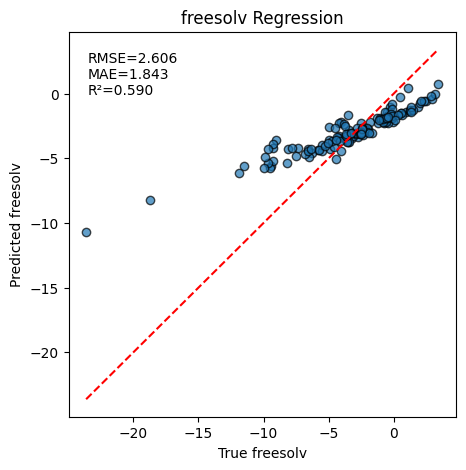

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, preds, alpha=0.7, edgecolor='k')
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel(f'True {tgt}')
plt.ylabel(f'Predicted {tgt}')
plt.title(f'{tgt} Regression')
plt.text(0.05, 0.95, f"RMSE={rmse:.3f}\nMAE={mae:.3f}\nR\u00b2={r2:.3f}",
         transform=plt.gca().transAxes, verticalalignment='top')
plt.show()